# Prediction stock returns with linear regression

## Imports & Settings

In [96]:
import warnings
warnings.filterwarnings('ignore')

In [97]:
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [98]:
sns.set_style('darkgrid')
idx = pd.IndexSlice
store_path = 'E:/ML4T/C7/data.h5'

In [99]:
YEAR = 252

## Load Data

In [100]:
with pd.HDFStore(store_path) as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [101]:
data.index.names = ['symbol', 'date']

In [102]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

### Select Investment Universe

In [103]:
data = data[data.dollar_vol_rank<100]

In [104]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d    

volume     dollar_vol  dollar_vol_1m  dollar_vol_rank  \
symbol date                                                                     
AAL    2013-07-25  9851.900173  482021.770518  223614.661574             91.0   
       2013-07-26  7797.700026  386784.252060  234821.351626             83.0   
       2013-07-29  6462.699829  322916.026692  243001.954091             78.0   
       2013-07-30  6091.900156  303913.741002  243122.621493             79.0   
       2013-07-31  9571.100178  481215.006566  256336.659780             75.0   
...                        ...            ...            ...              ...   
ZTS    2014-11-28  1332.156000   58600.308107  294715.115434             90.0   
       2014-12-01  3153.115000  136973.841193  297525.671580             92.0   
       2014-12-02  2500.597000  109533.781479  298272.515355             88.0   
       2014-12-03  2008.310000   88245.383471  295315.035852             87.0   
       2014-12-04  4294.633000  185006.560464  286390.276661             95.0   

                         rsi   bb_high    bb_low       atr      macd  \
symbol date                                                            
AAL    2013-07-25  69.669475  0.011251  0.140777 -0.383445  0.681257   
       2013-07-26  72.045207  0.007052  0.146370 -0.412740  0.772848   
       2013-07-29  73.259776  0.008843  0.146963 -0.494894  0.854980   
       2013-07-30  72.532538  0.018500  0.142355 -0.565684  0.904814   
       2013-07-31  73.926238  0.016465  0.139949 -0.653399  0.954135   
...                      ...       ...       ...       ...       ...   
ZTS    2014-11-28  71.884144  0.043559  0.157493  0.397024  2.806829   
       2014-12-01  67.137279  0.051976  0.131103  0.403122  2.691178   
       2014-12-02  68.612084  0.041573  0.120638  0.323857  2.615256   
       2014-12-03  69.175766  0.038192  0.111125  0.236555  2.540352   
       2014-12-04  61.677853  0.051743  0.080568  0.273293  2.329735   

                   return_1d  ...  consumer_durables  consumer_non-durables  \
symbol date                   ...                                             
AAL    2013-07-25   0.017838  ...              False                  False   
       2013-07-26   0.013808  ...              False                  False   
       2013-07-29   0.007334  ...              False                  False   
       2013-07-30  -0.001560  ...              False                  False   
       2013-07-31   0.007813  ...              False                  False   
...                      ...  ...                ...                    ...   
ZTS    2014-11-28   0.005820  ...              False                  False   
       2014-12-01  -0.012464  ...              False                  False   
       2014-12-02   0.008339  ...              False                  False   
       2014-12-03   0.003129  ...              False                  False   
       2014-12-04  -0.019608  ...              False                  False   

                   consumer_services  energy  finance  health_care  \
symbol date                                                          
AAL    2013-07-25              False   False    False        False   
       2013-07-26              False   False    False        False   
       2013-07-29              False   False    False        False   
       2013-07-30              False   False    False        False   
       2013-07-31              False   False    False        False   
...                              ...     ...      ...          ...   
ZTS    2014-11-28              False   False    False         True   
       2014-12-01              False   False    False         True   
       2014-12-02              False   False    False         True   
       2014-12-03              False   False    False         True   
       2014-12-04              False   False    False         True   

                   miscellaneous  public_utilities  technology  transportation  
symbol date  

### Create Model Data

In [105]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [106]:
y

target_1d  target_5d  target_10d  target_21d
symbol date                                                    
AAL    2013-07-25   0.013808   0.005775    0.000794   -0.007255
       2013-07-26   0.007334  -0.001787   -0.002597   -0.007757
       2013-07-29  -0.001560  -0.000625   -0.002153   -0.010307
       2013-07-30   0.007813  -0.002934   -0.015880   -0.010631
       2013-07-31   0.001550  -0.005011   -0.017793   -0.009130
...                      ...        ...         ...         ...
ZTS    2014-11-28  -0.012464  -0.004265   -0.007266   -0.001703
       2014-12-01   0.008339  -0.001220   -0.006092   -0.001459
       2014-12-02   0.003129  -0.004147   -0.009055   -0.001546
       2014-12-03  -0.019608  -0.009585   -0.008687   -0.001980
       2014-12-04  -0.000455  -0.005144   -0.001949   -0.001505

[109675 rows x 4 columns]

In [107]:
X

dollar_vol_1m        rsi   bb_high    bb_low       atr  \
symbol date                                                                 
AAL    2013-07-25  223614.661574  69.669475  0.011251  0.140777 -0.383445   
       2013-07-26  234821.351626  72.045207  0.007052  0.146370 -0.412740   
       2013-07-29  243001.954091  73.259776  0.008843  0.146963 -0.494894   
       2013-07-30  243122.621493  72.532538  0.018500  0.142355 -0.565684   
       2013-07-31  256336.659780  73.926238  0.016465  0.139949 -0.653399   
...                          ...        ...       ...       ...       ...   
ZTS    2014-11-28  294715.115434  71.884144  0.043559  0.157493  0.397024   
       2014-12-01  297525.671580  67.137279  0.051976  0.131103  0.403122   
       2014-12-02  298272.515355  68.612084  0.041573  0.120638  0.323857   
       2014-12-03  295315.035852  69.175766  0.038192  0.111125  0.236555   
       2014-12-04  286390.276661  61.677853  0.051743  0.080568  0.273293   

                       macd  return_1d  return_5d  return_10d  return_21d  \
symbol date                                                                 
AAL    2013-07-25  0.681257   0.017838   0.004413    0.008103    0.006426   
       2013-07-26  0.772848   0.013808   0.009262    0.008389    0.007936   
       2013-07-29  0.854980   0.007334   0.011627    0.007984    0.007873   
       2013-07-30  0.904814  -0.001560   0.012430    0.006755    0.007476   
       2013-07-31  0.954135   0.007813   0.009025    0.004774    0.006752   
...                     ...        ...        ...         ...         ...   
ZTS    2014-11-28  2.806829   0.005820   0.008117    0.003841    0.009878   
       2014-12-01  2.691178  -0.012464   0.002269    0.002815    0.008365   
       2014-12-02  2.615256   0.008339   0.000717    0.001147    0.009064   
       2014-12-03  2.540352   0.003129   0.004380    0.001551    0.008311   
       2014-12-04  2.329735  -0.019608  -0.003018    0.001374    0.005614   

                   ...  capital_goods  consumer_non-durables  \
symbol date        ...                                         
AAL    2013-07-25  ...          False                  False   
       2013-07-26  ...          False                  False   
       2013-07-29  ...          False                  False   
       2013-07-30  ...          False                  False   
       2013-07-31  ...          False                  False   
...                ...            ...                    ...   
ZTS    2014-11-28  ...          False                  False   
       2014-12-01  ...          False                  False   
       2014-12-02  ...          False                  False   
       2014-12-03  ...          False                  False   
       2014-12-04  ...          False                  False   

                   consumer_services  energy  finance  health_care  \
symbol date                                                          
AAL    2013-07-25              False   False    False        False   
       2013-07-26              False   False    False        False   
       2013-07-29              False   False    False        False   
       2013-07-30              False   False    False        False   
       2013-07-31              False   False    False        False   
...                              ...     ...      ...          ...   
ZTS    2014-11-28              False   False    False         True   
       2014-12-01              False   False    False         True   
       2014-12-02              False   False    False         True   
       2014-12-03              False   False    False         True   
       2014-12-04              False   False    False         True   

                   miscellaneous  public_utilities  technology  transportation  
symbol date                                                                     
AAL    2013-07-25          False             False       False            True  
       2013-07-26          F

## Custom MultipleTimeSeriesCV

In [108]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Verify that it works

In [112]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [124]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = pd.concat([train.reset_index(), test.reset_index()], axis=0)
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


## Visualization helper functions

### Prediction vs Actual Scatter Plot

In [115]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

### Daily IC Distribution

In [116]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

### Rolling Daily IC

In [117]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

## Linear Regression with sklearn

### Set up cross-validation

In [118]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation with LinearRegression 

In [119]:
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: total: 1 s
Wall time: 901 ms


In [120]:
lr_scores

,ic,rmse
date,,
2017-11-15,14.975550,0.019839
2017-11-16,-26.598103,0.011923
2017-11-17,38.779336,0.010337
2017-11-20,35.754771,0.012877
2017-11-21,-39.360786,0.009570
...,...,...
2014-12-16,-14.317873,0.031289
2014-12-17,31.454545,0.028132
2014-12-18,-44.676562,0.021422


In [121]:
lr_predictions

actuals  predicted
symbol date                           
AAPL   2017-11-15  0.011947  -0.001070
       2017-11-16 -0.005552  -0.000177
       2017-11-17 -0.000999  -0.000833
       2017-11-20  0.018590  -0.000467
       2017-11-21  0.010512   0.000103
...                     ...        ...
XOM    2014-12-16  0.030205  -0.001093
       2014-12-17  0.024040  -0.001359
       2014-12-18  0.027205  -0.000944
       2014-12-19 -0.003311  -0.001867
       2014-12-22  0.013500  -0.002199

[74054 rows x 2 columns]

### Persist results

In [65]:
lr_scores.to_hdf(store_path, 'lr/scores')
lr_predictions.to_hdf(store_path, 'lr/predictions')

In [66]:
lr_scores = pd.read_hdf(store_path, 'lr/scores')
lr_predictions = pd.read_hdf(store_path, 'lr/predictions')

### Evaluate results

In [67]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 1.531% (p-value: 0.0031%)


#### Prediction vs Actuals Scatter

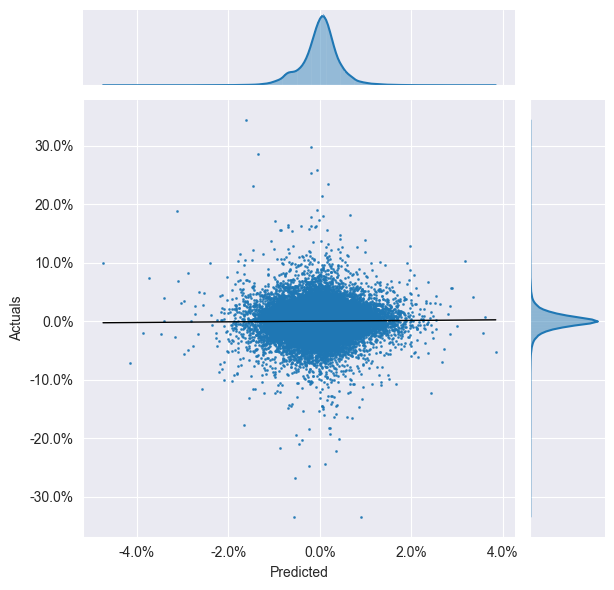

In [68]:
plot_preds_scatter(lr_predictions)

#### Daily IC Distribution

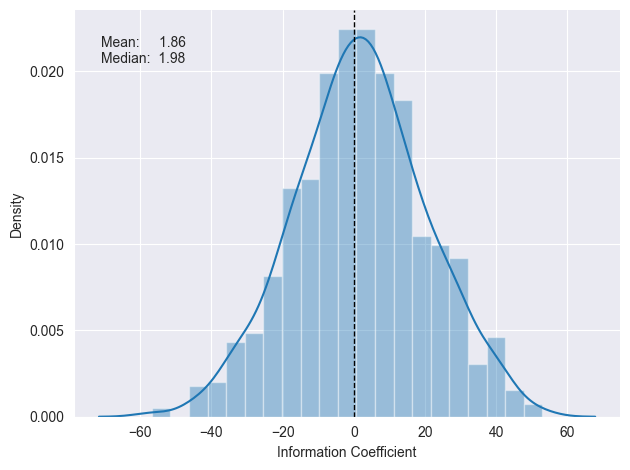

In [69]:
plot_ic_distribution(lr_scores)

#### Rolling Daily IC

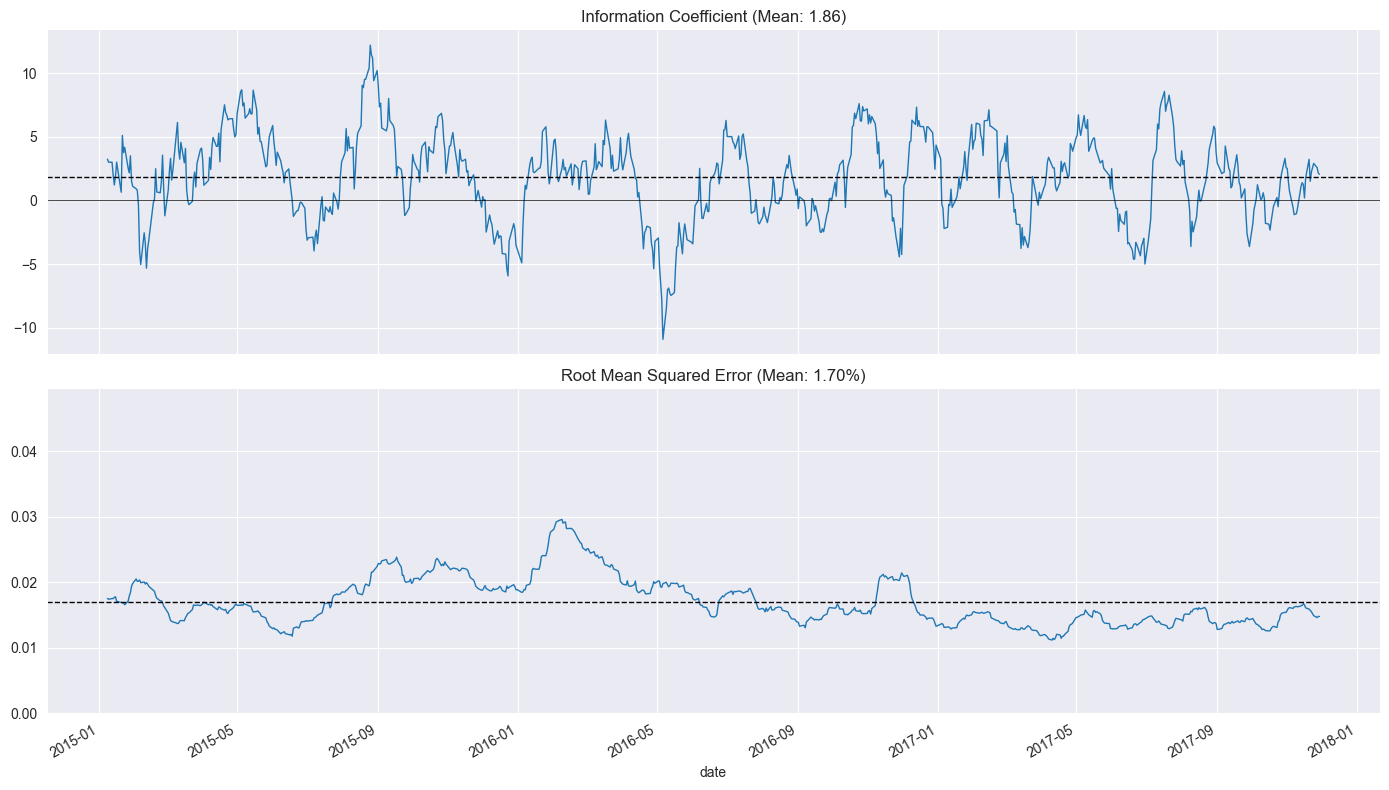

In [70]:
plot_rolling_ic(lr_scores)

## Ridge Regression

### Define cross-validation parameters

In [71]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [72]:
n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation

In [73]:
target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [74]:
%%time
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: total: 21.2 s
Wall time: 21.1 s


### Persist results

In [75]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf(store_path, 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf(store_path, 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf(store_path, 'ridge/predictions')

In [76]:
ridge_scores = pd.read_hdf(store_path, 'ridge/scores')
ridge_coeffs = pd.read_hdf(store_path, 'ridge/coeffs')
ridge_predictions = pd.read_hdf(store_path, 'ridge/predictions')

### Evaluate Ridge Results

In [77]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 1.551% (p-value: 0.0000%)


In [78]:
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0005,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0010,750.0,1.863889,18.565640,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0050,750.0,1.863890,18.565617,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0100,750.0,1.864012,18.565426,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.0500,750.0,1.864657,18.566158,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.1000,750.0,1.864743,18.566752,-56.788054,-10.005566,1.981447,14.096177,53.021645
0.5000,750.0,1.863531,18.566137,-56.835055,-9.996599,1.966605,14.124337,53.034014
1.0000,750.0,1.863910,18.566893,-56.835055,-9.996599,1.966605,14.110091,53.161410


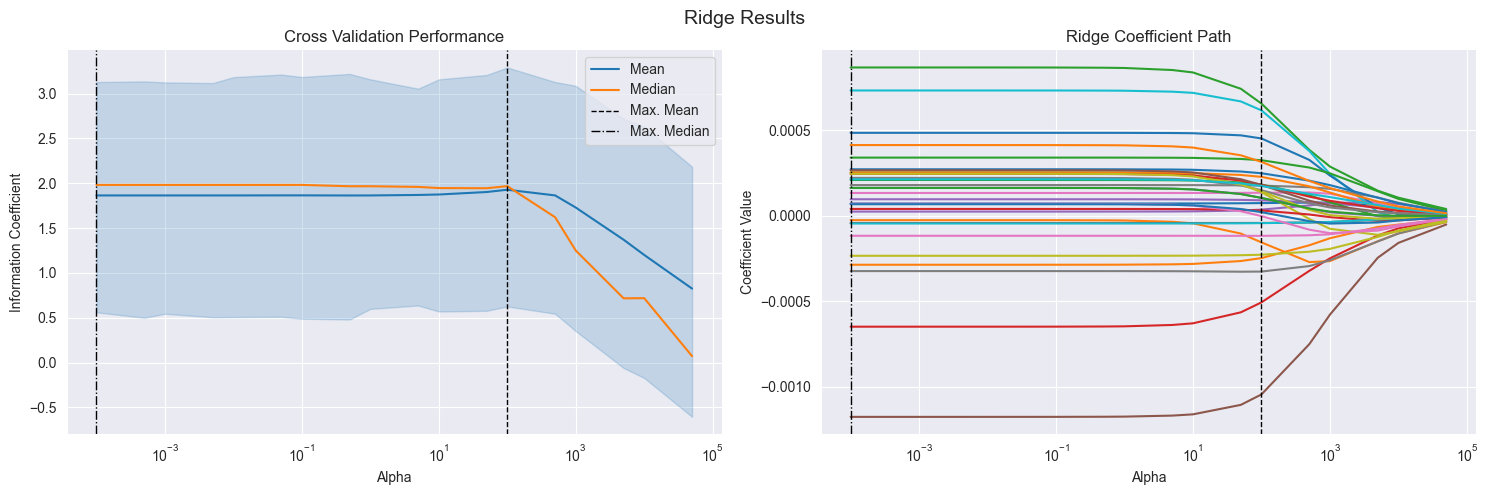

In [79]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

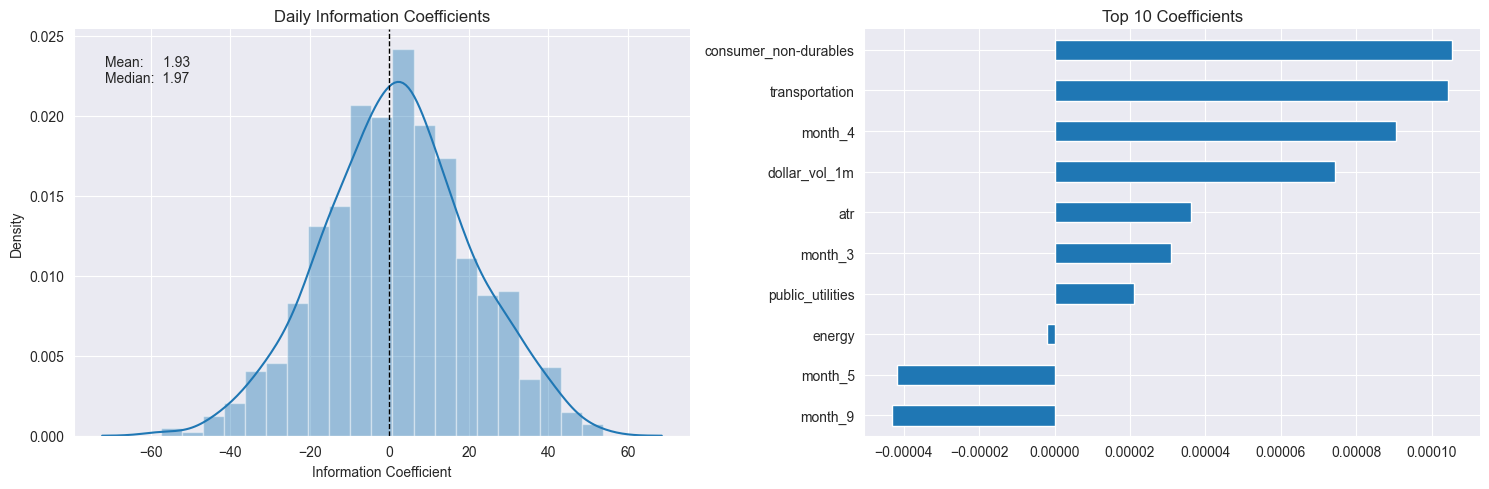

In [80]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

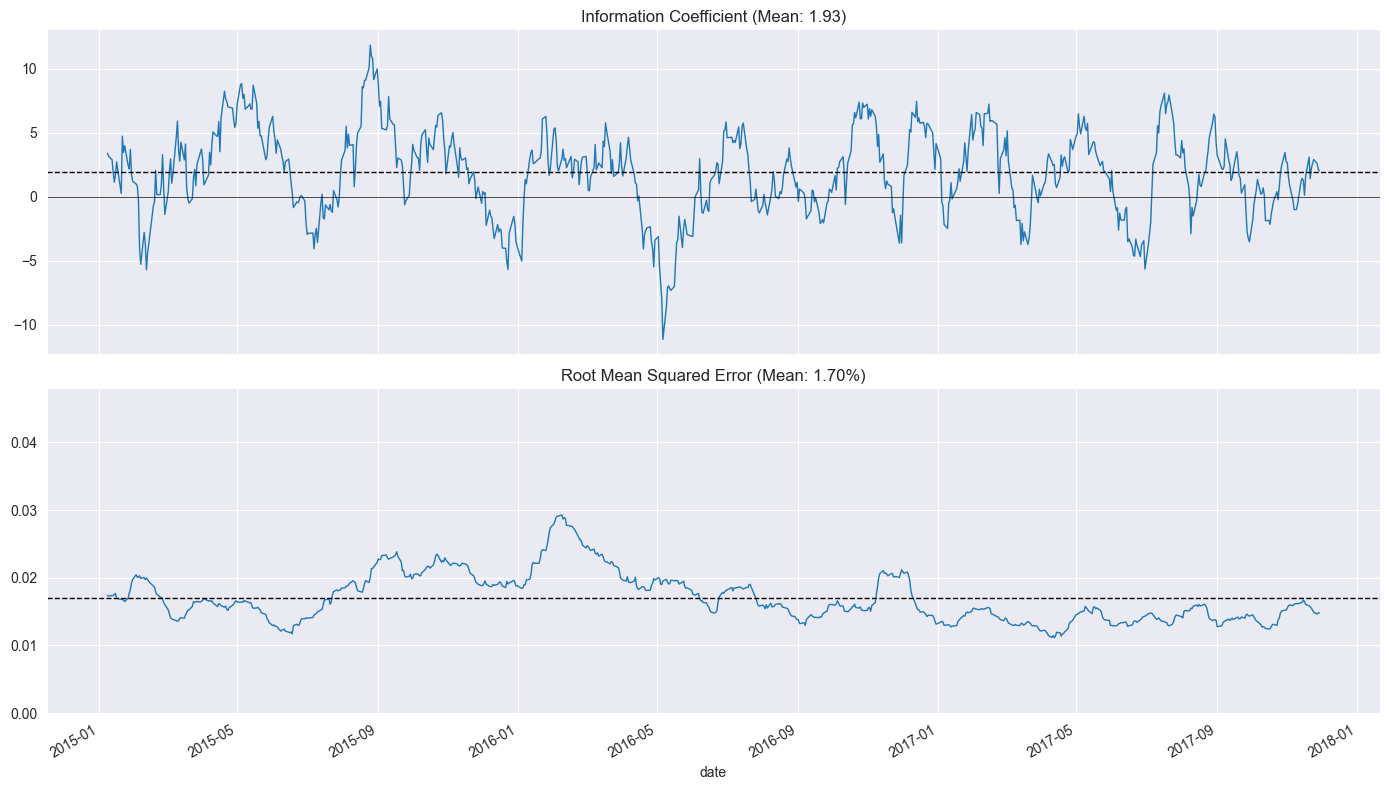

In [81]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

## Lasso CV

### Define cross-validation parameters

In [82]:
lasso_alphas = np.logspace(-10, -3, 8)

In [83]:
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1

In [84]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

### Run cross-validation with Lasso regression

In [85]:
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [86]:
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 CPU times: total: 40.3 s
Wall time: 32.2 s


### Persist results

In [87]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf(store_path, 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf(store_path, 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf(store_path, 'lasso/predictions')

### Evaluate Lasso Results

In [88]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 3.595% (p-value: 0.0000%)


In [89]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,1.863889,1.981447
1.000000e-09,1.863758,1.981447
1.000000e-08,1.864487,1.981447
1.000000e-07,1.865393,1.966605
1.000000e-06,1.875294,1.962276
1.000000e-05,1.935876,2.191108
1.000000e-04,1.575376,1.012989
1.000000e-03,1.025462,1.768092


### Lasso Coefficient Path

ValueError: cannot reindex on an axis with duplicate labels

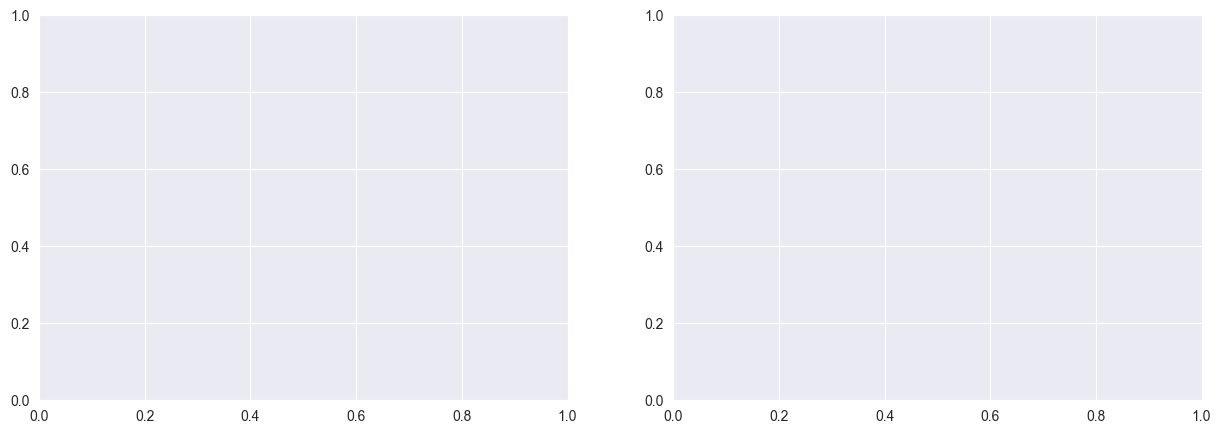

In [90]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

### Lasso IC Distribution and Top 10 Features

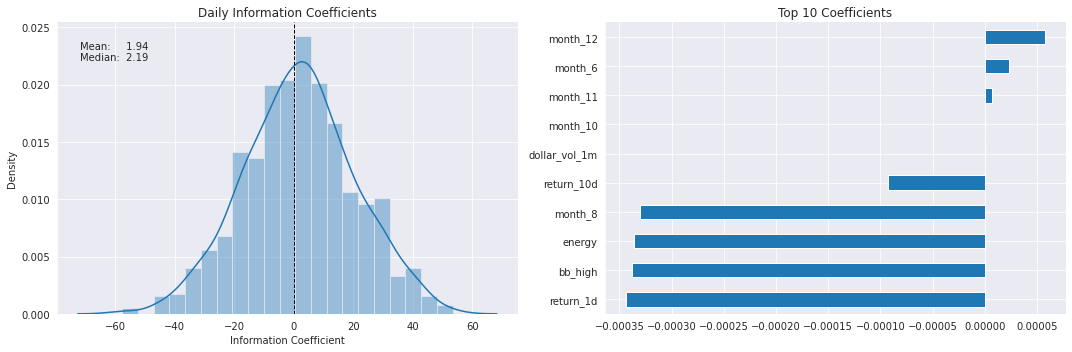

In [ ]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

## Compare results

In [ ]:
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [ ]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [ ]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

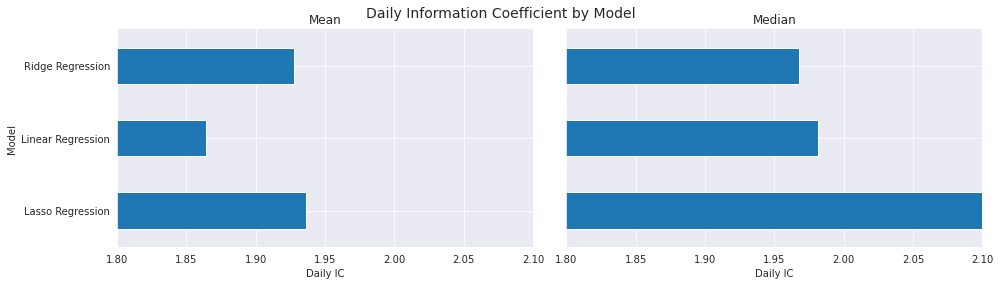

In [ ]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1.85, 2), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1.8, 2.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)